In [15]:
import numpy as np
from tqdm import tqdm
import scipy
from scipy import sparse
import pickle as pkl
import scipy.sparse as sparse
from scipy.special import softmax
import matplotlib.pyplot as plt
import json
import random
from tqdm import tqdm
import csv
import math
import nltk
import operator
import os
from collections import defaultdict

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter
from sklearn import manifold, datasets
from time import time

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import networkx as nx

import easydict
import time
import sys
import tensorflow as tf
from tensorflow.python.util import deprecation

from src.minibatch import EdgeBatch, NeighborSampler
from src.model import LayerInfo, UnsupervisedSAGE

### graph generator

In [62]:
n_node = 500
d_attr = 20

# generate node attributes
X = np.random.uniform(-1., 1., (n_node, d_attr))
# X = np.eye(n_node)

# calculate node similarity
S_orig = X.dot(X.T)
S_exp = np.exp(S_orig)
S_exp_sum = np.expand_dims(np.sum(S_exp, axis=1), 1)
S = S_exp/S_exp_sum

# generate probability of knowing each other
K = np.random.uniform(0., 1., (n_node, n_node))   

# generate edge based on Binomial(S[i][j])*Binomial(K[i][j])
# generate random matrix first
random_matrix = np.random.random((n_node, n_node))/10.
A_unbias = random_matrix < S
A_unbias = A_unbias.astype(int)
A_bias = random_matrix < S*K
A_bias = A_bias.astype(int)

# show clean graph
G_unbias = nx.from_numpy_matrix(A_unbias)
nx.draw(G_unbias, pos=nx.spring_layout(G_unbias))
degree_unbias = nx.degree_centrality(G_unbias)
print (degree_unbias)

{0: 7, 1: 9, 2: 7, 3: 10, 4: 15, 5: 12, 6: 8, 7: 7, 8: 4, 9: 12, 10: 9, 11: 7, 12: 3, 13: 4, 14: 10, 15: 6, 16: 6, 17: 8, 18: 11, 19: 6, 20: 6, 21: 6, 22: 10, 23: 10, 24: 6, 25: 8, 26: 7, 27: 7, 28: 6, 29: 4, 30: 6, 31: 11, 32: 11, 33: 6, 34: 4, 35: 10, 36: 5, 37: 3, 38: 7, 39: 10, 40: 6, 41: 7, 42: 4, 43: 10, 44: 4, 45: 5, 46: 3, 47: 9, 48: 6, 49: 11, 50: 4, 51: 1, 52: 9, 53: 11, 54: 11, 55: 12, 56: 10, 57: 4, 58: 7, 59: 8, 60: 3, 61: 6, 62: 5, 63: 2, 64: 11, 65: 11, 66: 6, 67: 5, 68: 8, 69: 5, 70: 11, 71: 5, 72: 7, 73: 8, 74: 8, 75: 6, 76: 8, 77: 12, 78: 4, 79: 9, 80: 13, 81: 7, 82: 6, 83: 6, 84: 8, 85: 11, 86: 10, 87: 6, 88: 12, 89: 7, 90: 12, 91: 8, 92: 7, 93: 6, 94: 9, 95: 13, 96: 5, 97: 6, 98: 5, 99: 11, 100: 7, 101: 6, 102: 5, 103: 7, 104: 6, 105: 10, 106: 11, 107: 7, 108: 6, 109: 7, 110: 7, 111: 7, 112: 10, 113: 12, 114: 14, 115: 7, 116: 10, 117: 12, 118: 3, 119: 15, 120: 14, 121: 6, 122: 3, 123: 6, 124: 4, 125: 9, 126: 6, 127: 10, 128: 11, 129: 11, 130: 5, 131: 4, 132: 12, 133

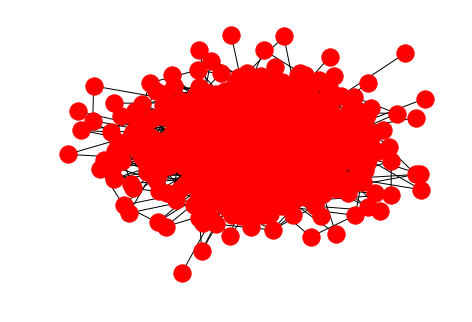

In [63]:
# show graph
G = nx.from_numpy_matrix(A_bias)
nx.draw(G, pos=nx.spring_layout(G))
degree = nx.degree(G)
print (degree)

In [90]:
# gen random walks
WALK_N = 100
WALK_LEN = 5
def gen_random_walk(G, nodes, seed):
    print ("===== generate random walk =====")
    rand = random.Random(seed)
    pairs = []
    for cnt, node in enumerate(nodes):
        if G.degree(node) == 0:
            continue
        for i in range(WALK_N):
            cur_node = node
            for j in range(WALK_LEN):
                next_node = rand.choice(G.neighbors(cur_node))
                # self co-occurrences are useless
                if cur_node != node:
                    pairs.append((node,cur_node))
                cur_node = next_node
        if cnt % 1000 == 0:
            print("--- Done walks for", cnt, "nodes")
    return pairs
walks = gen_random_walk(G, G.nodes(), 888)
print ('Generate {} walks'.format(len(walks)))

K[K<0.05]=0.05
with open("G.bin", 'wb') as f:
    pkl.dump(G, f)
with open("G_unbias.bin", 'wb') as f:
    pkl.dump(G_unbias, f)
with open("walks.bin", 'wb') as f:
    pkl.dump(walks, f)
with open("X.bin", 'wb') as f:
    pkl.dump(X, f)
with open("IPS.bin", 'wb') as f:
    pkl.dump(1./K, f)

===== generate random walk =====
--- Done walks for 0 nodes
Generate 180650 walks


{0: 17, 1: 19, 2: 14, 3: 13, 4: 22, 5: 20, 6: 17, 7: 7, 8: 8, 9: 16, 10: 11, 11: 12, 12: 14, 13: 8, 14: 15, 15: 13, 16: 9, 17: 13, 18: 15, 19: 14, 20: 9, 21: 10, 22: 17, 23: 18, 24: 13, 25: 16, 26: 16, 27: 11, 28: 12, 29: 9, 30: 10, 31: 18, 32: 20, 33: 6, 34: 12, 35: 16, 36: 9, 37: 12, 38: 10, 39: 15, 40: 13, 41: 13, 42: 17, 43: 20, 44: 12, 45: 9, 46: 12, 47: 11, 48: 10, 49: 20, 50: 12, 51: 11, 52: 17, 53: 22, 54: 20, 55: 25, 56: 20, 57: 7, 58: 16, 59: 13, 60: 9, 61: 9, 62: 10, 63: 10, 64: 14, 65: 18, 66: 20, 67: 8, 68: 14, 69: 14, 70: 22, 71: 20, 72: 14, 73: 14, 74: 19, 75: 9, 76: 15, 77: 16, 78: 8, 79: 15, 80: 19, 81: 12, 82: 18, 83: 15, 84: 14, 85: 20, 86: 17, 87: 14, 88: 12, 89: 14, 90: 16, 91: 11, 92: 11, 93: 15, 94: 10, 95: 16, 96: 12, 97: 13, 98: 12, 99: 19, 100: 13, 101: 12, 102: 11, 103: 10, 104: 9, 105: 15, 106: 20, 107: 9, 108: 21, 109: 11, 110: 11, 111: 15, 112: 13, 113: 15, 114: 19, 115: 13, 116: 17, 117: 16, 118: 11, 119: 22, 120: 21, 121: 11, 122: 6, 123: 12, 124: 5, 125

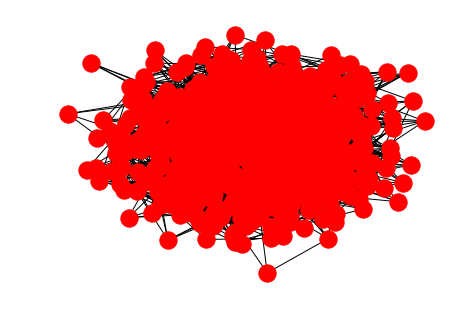

In [74]:
# show clean graph
G_unbias = nx.from_numpy_matrix(A_unbias)
nx.draw(G_unbias, pos=nx.spring_layout(G_unbias))
degree_unbias = nx.degree(G_unbias)
print (degree_unbias)
with open("G_unbias.bin", 'wb') as f:
    pkl.dump(G_unbias, f)

### evaluation

In [97]:
with open("G_unbias.bin", 'rb') as f:
    G_unbias = pkl.load(f)
with open("G.bin", 'rb') as f:
    G = pkl.load(f)
with open("embedding.bin", 'rb') as f:
    (node, embed) = pkl.load(f)
with open("embedding_IPS.bin", 'rb') as f:
    (node_IPS, embed_IPS) = pkl.load(f)

embedding_noIPS = np.zeros((len(embed), len(embed[0])))
embedding_IPS = np.zeros((len(embed_IPS), len(embed_IPS[0])))
for i in range(len(embed)):
    embedding_noIPS[node[i]] = embed[i]
    embedding_IPS[node_IPS[i]] = embed_IPS[i]

In [98]:
# evaluate MAP, MRR, NDCG
G_test = G_unbias
embeddings = embedding_noIPS
scale = 5
res = []
# seeds = [4, 48, 488, 4888, 48888, 488888]
seeds = [488]
for seed in seeds:
    rand = random.Random(seed)
    maps = []
    mrrs = []
    ndcgs = []
    try:
        with tqdm(range(len(G_test.nodes()))) as nodes:
            for u in nodes:
                ref = G_test.neighbors(u)
                if len(ref) < 1:
                    continue
                    
                left = list(set(range(len(G_test.nodes()))) - set(ref))
                candi = rand.sample(left, min(2 * len(ref), len(left))) + ref
                
                dist_list = []
                for v in candi:
                    dist_list.append(scipy.spatial.distance.cosine(embeddings[u], embeddings[v]))
                rank = np.argsort(np.array(dist_list)).tolist()
                pred = np.array(candi)[np.array(rank)]
                
                # MAP
                map_tmp = 0
                count = 0
                for i, q in enumerate(pred):
                    if q in ref:
                        count += 1
                        map_tmp += count / (i+1)
                map_tmp = map_tmp / len(ref)
                maps.append(map_tmp)

                # MRR
                mrr_tmp = 0
                count = 0
                for i, q in enumerate(pred):
                    if q in ref:
                        mrr_tmp = 1 / (math.ceil((i+1) / scale))
                mrrs.append(mrr_tmp)
                
                # NDCG
                rels = []
                for i, q in enumerate(pred):
                    if q in ref:
                        rels.append(1.)
                    else:
                        rels.append(0.)
                dcg = [rels[i]/math.log(i+2, 2) for i in range(len(rels))]
                ideal_refs = np.sort(rels)[::-1]
                idcg = [ideal_refs[i]/math.log(i+2, 2) for i in range(len(rels))]
                ndcgs.append(sum(dcg) / sum(idcg))
                    
    except KeyboardInterrupt:
        users.close()
        raise
    nodes.close()
    maps = np.array(maps)
    mrrs = np.array(mrrs)
    ncdgs = np.array(ndcgs)
    map_mean, map_var = np.mean(maps), np.var(maps)
    mrr_mean, mrr_var = np.mean(mrrs), np.var(mrrs)
    ndcg_mean, ndcg_var = np.mean(ndcgs), np.var(ndcgs)
    print('{}/{} users: MAP={}+-{}, MRR={}+-{}, NDCG={}+-{}'.format(maps.shape[0], len(G_test.nodes()),
                                                                    map_mean, map_var,
                                                                    mrr_mean, mrr_var,
                                                                    ndcg_mean, ndcg_var))
    res.append([map_mean, mrr_mean, ndcg_mean])

res = np.array(res)
res_mean, res_std = np.mean(res, 0), np.std(res, 0)
print ('MAP: {}+-{}'.format(res_mean[0], res_std[0]))
print ('MRR: {}+-{}'.format(res_mean[1], res_std[1]))
print ('NDCG: {}+-{}'.format(res_mean[2], res_std[2]))

100%|██████████| 500/500 [00:00<00:00, 1020.02it/s]

500/500 users: MAP=0.7018335797522631+-0.01226456246203428, MRR=0.17402635142635142+-0.006240024971063026, NDCG=0.894498217984447+-0.0025193265389290833
MAP: 0.7018335797522631+-0.0
MRR: 0.17402635142635142+-0.0
NDCG: 0.894498217984447+-0.0
